In [1]:
import numpy as np
import matplotlib

# Embed fonts into PDF/PS files
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors

import scipy.integrate
import scipy.optimize

# Progress bars
import tqdm.notebook

# Make deep copies
import copy

In [2]:
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial']})

In [3]:
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

# Figure 4A,D – show relation of full to simplified model

In [4]:
## Physiological parameters

# mvn head sensitvity in the light: 0.38 sp/s / deg/s for ~0.85 gain -- Beraneck & Cullen 2007
# => k_eye ~= 2.2

# Eye movement response to optogenetic stimulation (Payne et al. 2019)
# ~0.1 deg/s / sp/s = k_eye * w_PC => w_PC ~= 0.05

# average learning in one day ~20-40% (Kimpo et al. 2014, Boyden & Raymond 2003)
# delta w ~= delta g/g_0 * v_0*k_MF / w_pc_mvn*k_PF
# delta g/g_0 ~= 0.3 = > delta w ~= -2.6
# => for ~50% decrease during training (Jang, Shim et al. 2020), set w_i = 5

# memory retention ~75% after 24 hr calculated from Boyden & Raymond 2003

params = {
    'mf_0': 55, # Lasker et al. 2008
    'pf_0': 14, # Arenz et al. 2008 -- assume each MF EPSC evokes a GC spike
    'cf_0': 1,
    'mf_sensitivity': 0.14, # Lasker et al. 2008
    'pf_sensitivity': 0.42, # Arenz et al. 2008 (See above)
    'w_i': 5, # calculated from Jang, Shim et al. 2020 as above
    'w_pc_mvn': 0.05, # calculated from Payne et al. 2019 as above
    'k_eye': 2.2, # calculated from Beraneck & Cullen 2007 as above
    'k_v':2.75e-5, # empirically, to get 75% retention
    'tau_f': 0.017, # fast average ~= 1 min
    'tau_mvn': 0.7, # tau_f,v: average of activity being integrated at MVN
    'tau_learn': 0.15, # Boyden & Raymond 2003
    'tau_post': 5, # consistent with 4 hour window, Attwell et al. 2002
    'k_LTD': 0.648, # to get delta w ~= -2.6
    'beta_rs':1, # to match CF response curve from Guo et al. 2014
}
# Set k_LTP so that LTP and LTD contributions to plasticity at w offset when not learning
params['k_LTP'] = params['k_LTD']*params['cf_0']

## Behavioral parameters

# Kimpo et al. 2014, Nguyen-Vu et al. 2013, Boyden & Raymond 2003
stim_freq = 1 
peak_velocity_learn = 15 # deg/s
peak_velocity_post = 15

# Define function for head velocity
head_learn = lambda t: peak_velocity_learn*np.sin(2*np.pi*stim_freq*3600*t)
head_post_input = lambda t: peak_velocity_post*np.sin(2*np.pi*stim_freq*3600*t) # w/post-training input
head_post_no_input = lambda t: 0 # w/o post-training input

# Define function for retinal slip
target_learn = lambda t: -peak_velocity_learn*np.sin(2*np.pi*stim_freq*3600*t) # x2 stimulus
target_post = lambda t: 0

In [46]:
print(params['k_LTP']) # note this is different from models with decay in w_H

0.648


In [5]:
gain = lambda w,v: params['k_eye']*(params['mf_sensitivity']*v 
                                    - params['pf_sensitivity']*params['w_pc_mvn']*(w-params['w_i']))
    

In [6]:
# initial gain ~- 0.4 in mice (Katoh et al. 2015, Boyden & Raymond 2003)
g_init = 0.4
v_0_ = lambda g_init: g_init/(params['k_eye']*params['mf_sensitivity'])

v_0 = v_0_(g_init)

In [7]:
# Spontaneous firing rate of PCs ~50 sp/s (Katoh et al. 2015) 
# and MVNs is ~57 sp/s (Nelson et al. 2003)

# Calculate PC and MVN offsets so that this is the firing rate at baseline
params['pc_0'] = 50
params['mvn_0'] = 57 - params['mf_0']*v_0 + params['w_pc_mvn']*50

## Simple one site model – Figure 4A

In [68]:
# Function to pass to ODE solver
def oneSite(t, y, head, target_gain, learn, params):
    '''
    head: a function taking a time argument that returns the head velocity
    retinal_slip: a function taking a time argument that returns the retinal slip velocity
    learn: set to True if in the training period, False if in the post-training period
    params: list containing the physiological parameters
    
    '''
    # cf = params['cf_0'] + delta_cf
    
    w = y[0]
    # set v to fixed value so that initial gain is 0.4
    v = v_0 # 0.4/(params['k_eye']*params['mf_sensitivity']) 
    
    g = params['k_eye']*(params['mf_sensitivity']*v - 
                         params['pf_sensitivity']*params['w_pc_mvn']*(w-params['w_i']))
    retinal_slip = -(target_gain - g)*head(t)
    
    delta_pf = params['pf_sensitivity']*head(t)
    delta_cf = np.tanh(-params['beta_rs']*retinal_slip)*learn
    pf = params['pf_0'] + delta_pf
    cf = params['cf_0'] + delta_cf
    
    dydt = np.zeros(3)
    dydt[0] = params['k_v']*( params['k_LTP']*y[1] - params['k_LTD']*y[2] )
    dydt[1] = 1/params['tau_f'] * (-y[1] + pf)
    dydt[2] = 1/params['tau_f'] * (-y[2] + pf*cf)
    
    return dydt

# Jacobian 
def oneSiteJac(t, y, head, target_gain, learn, params):
    w = y[0]
    v = v_0 # 0.4/(params['k_eye']*params['mf_sensitivity'])
    g = params['k_eye']*(params['mf_sensitivity']*v - 
                         params['pf_sensitivity']*params['w_pc_mvn']*(w-params['w_i']))
    retinal_slip = -(target_gain - g)*head(t)
    
    delta_pf = params['pf_sensitivity']*head(t)
    delta_cf = np.tanh(-params['beta_rs']*retinal_slip)*learn
    
    pf = params['pf_0'] + delta_pf

    dgdw = -params['k_eye']*params['pf_sensitivity']*params['w_pc_mvn']
    
    jac = np.zeros((3,3))
    jac[0,:] = params['k_v']*np.array([0, params['k_LTP'], -params['k_LTD']])
    jac[1,1] = -1/params['tau_f']
    jac[2,:] = 1/params['tau_f']*np.array([ -pf*(1-delta_cf**2)*params['beta_rs']*dgdw*head(t)*learn,
                                             0, -1])
    
    return jac

In [9]:
y_0_init = np.array([params['w_i'], params['pf_0'], params['pf_0']*params['cf_0']])
sigma2 = 0.5*peak_velocity_post**2

In [10]:
dt_learn = 1/3600 # h (= 1 s)
dt_post = 60/3600 # h (= 10 min)

T_learn = 0.5
T_post = 12

t_learn = np.linspace(0, T_learn, int(T_learn/dt_learn))
t_post = np.linspace(0, T_post-T_learn, int(T_post/dt_post)) + T_learn



In [11]:
# target gains for three days of training
g_des_ = np.array([0.4,  0.48, 0.36]) # np.array([0.4, 0.43, 0.38])

In [12]:
days = len(g_des_)
t_total = np.concatenate([np.concatenate((t_learn,t_post)) + d*T_post for d in range(days)])

### Fast learning at $w$

Below, we perform some calculations to pick parameters for the one-site model so that it is close to the simplified model given our choices of $q$.

Assuming that we are in the linear regime, 
$$
\begin{align*}
\dot{w} &\approx -k_\text{LTD}k_\text{PF}\beta_\text{rs}(g^\text{target}-g)\sigma_H^2\\
&= -k_\text{LTD}k_\text{PF}\beta_\text{rs}\sigma_H^2(g^\text{target}-k_E(\tilde{v}-w_\text{PC}\tilde{w})),
\end{align*}
$$
so the time constant of the exponential approach to steady state is
$$
\tau = \frac{1}{-k_\text{LTD}k_\text{PF}^2\sigma_H^2\beta_\text{rs}k_E w_\text{PC}}.
$$

Then, since $w(t) \approx w_\infty - (w_\infty - w_0)e^{-t/\tau}$, the amount of learning at the end of the training period is
$$
w(T) - w_0 = (w_\infty - w_0)(1 - e^{-t/\tau}) \Rightarrow 1 - e^{-t/\tau} = q,
$$
where $q$ is the fraction of the total change in $w$ learned (and hence the fraction of the ideal gain change learned). Given a value of $q$, the ideal value of the $k_\text{LTD}$ to acheive it in the linear regime is then
$$
k_\text{LTD} = \frac{-\log(1-q)}{T k_\text{PF}^2 \sigma_H^2 \beta_\text{rs} k_E w_\text{PC}}.
$$

In [96]:
# To achieve 75% learning:
k_w_fast = -np.log(1-0.75)/(T_learn * params['pf_sensitivity']**2*sigma2*params['beta_rs']*
                           params['k_eye']*params['w_pc_mvn'])
print(k_w_fast)

1.2701109609655659


If the retinal slip is large enough that the learning is saturated, then we have
$$
\dot{w} \approx -k_\text{LTD}k_\text{PF}\langle|\dot{H}|\rangle \approx -k_\text{LTD}k_\text{PF}\cdot\frac{2}{\pi}v_p,
$$
where $v_p$ is the peak velocity of the training stimulus.

Then, the fraction learned after training is
$$
q = \frac{w(T) - w_0}{w^* - w_0} = \frac{-k_\text{LTD}k_\text{PF}2/\pi \cdot v_p}{w^* - w_0},
$$
which implies that
$$
k_\text{LTD} = -\frac{q(w^* - w_0) + w_0}{k_\text{PF}\cdot2/\pi\cdot v_p}
$$

This depends on the particular value of $w^*$ given a target gain value.

In [87]:
params_onesite = copy.deepcopy(params)

In [108]:
params_onesite['k_v'] = k_w_fast*1.75 # since in simulation, learning is a bit less than ideal

In [109]:
params_onesite['k_v']

2.2226941816897403

In [110]:
t_len_total = len(t_learn)+len(t_post)
y_fast = np.zeros((len(y_0_init), t_len_total*days))

y_0 = y_0_init
for d in range(days):
    sol_learn = scipy.integrate.solve_ivp(lambda t,y: oneSite(t,y, head_learn, g_des_[d], True, params_onesite), [0, T_learn], y_0, 
                                      jac=lambda t,y: oneSiteJac(t,y,head_learn, g_des_[d],True,params_onesite), method='Radau', dense_output=True) # , max_step=0.25/3600)
    y_learn = sol_learn.sol(t_learn)
    
    sol_recov = scipy.integrate.solve_ivp(lambda t,y: oneSite(t,y, head_post_input, g_des_[d], False, params_onesite), [T_learn, T_post],
                                          y_learn[:,-1], 
                                          jac=lambda t,y: oneSiteJac(t,y,head_post_input, g_des_[d],False,params_onesite), method='Radau', dense_output=True) #,  max_step=0.25/3600)
    y_recov = sol_recov.sol(t_post)
    y_0 = y_recov[:,-1]
    y_fast[:,t_len_total*d:t_len_total*(d+1)] = np.hstack((y_learn, y_recov))

### Slow learning at $w$

In [83]:
params_onesite_slow = copy.deepcopy(params)

In [116]:
# To achieve 10% learning:
k_w_slow = -np.log(1-0.1)/(T_learn * params['pf_sensitivity']**2*sigma2*params['beta_rs']*
                           params['k_eye']*params['w_pc_mvn'])
print(k_w_slow)

0.09653039754261555


In [123]:
params_onesite_slow['k_v'] = k_w_slow*2
params_onesite_slow['tau_mvn'] = 5/60

In [118]:
params_onesite_slow['k_v']

0.09653039754261555

In [124]:
y_slow = np.zeros((len(y_0_init), t_len_total*days))

y_0 = y_0_init
for d in range(days):
    sol_learn = scipy.integrate.solve_ivp(lambda t,y: oneSite(t,y, head_learn, g_des_[d], True, params_onesite_slow), [0, T_learn], y_0, 
                                      jac=lambda t,y: oneSiteJac(t,y,head_learn, g_des_[d],True,params_onesite_slow), method='Radau', dense_output=True)
    y_learn = sol_learn.sol(t_learn)
    
    sol_recov = scipy.integrate.solve_ivp(lambda t,y: oneSite(t,y, head_post_input, g_des_[d], False, params_onesite_slow), [T_learn, T_post],
                                          y_learn[:,-1], 
                                          jac=lambda t,y: oneSiteJac(t,y,head_post_input, g_des_[d],False,params_onesite_slow), method='Radau', dense_output=True)
    y_recov = sol_recov.sol(t_post)
    y_0 = y_recov[:,-1]
    y_slow[:,t_len_total*d:t_len_total*(d+1)] = np.hstack((y_learn, y_recov))

### Plots (Figure 4A)

In [125]:
# v0 = 0.4/(params['k_eye']*params['mf_sensitivity'])
g_actual = gain(y_fast[0,:],v_0)
g_actual_slow = gain(y_slow[0,:],v_0)

Indices to slice `y_fast` and `y_slow` for the two example training steps:

In [128]:
ind_train = np.arange(0,len(t_learn),dtype=int) # just the time of learning
ind_train_extended = np.arange(-5,len(t_learn)+15,dtype=int) # with some padding

Amount of learning achieved (to adjust choice of $k_v$):

In [126]:
# Actual learning -- ideal = 10% 
((g_actual_slow[int(2*t_len_total)-1] - g_actual_slow[ind_train[0] + int(t_len_total)])/
 (g_des_[1] - g_actual_slow[ind_train[0] + int(t_len_total)]))*100

9.496899247517785

In [127]:
# Actual learning -- ideal = 10% 
((g_actual_slow[-1] - g_actual_slow[ind_train[0] + 2*int(t_len_total)])/
 (g_des_[2] - g_actual_slow[ind_train[0] + 2*int(t_len_total)]))*100

11.723010309442945

In [114]:
# Ideal = 80%
# 1st step
((g_actual[int(2*t_len_total)-1] - g_actual[ind_train[0] + int(t_len_total)])/
 (g_des_[1] - g_actual[ind_train[0] + int(t_len_total)]))*100

76.103789708312

In [115]:
# Ideal = 80%
# 2nd step
((g_actual[-1] - g_actual[ind_train[0] + int(2*t_len_total)])/
 (g_des_[2] - g_actual[ind_train[0] + int(2*t_len_total)]))*100

74.64856514669357

In [130]:
# gain_train_t2 = np.array([0,0, len(t_learn), len(t_learn)])
gain_train_t = np.array([0, len(t_learn)])

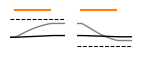

In [184]:
plt.figure(figsize=(4/2.54,1.5/2.54))

ax = plt.subplot(1,2,1)
plt.plot(t_total[ind_train_extended + int(t_len_total)], g_actual[ind_train_extended+int(t_len_total)],c=(0.5,)*3,lw=1)
plt.plot(t_total[ind_train_extended + int(t_len_total)], g_actual_slow[ind_train_extended+int(t_len_total)],c='k',lw=1)
plt.plot([t_total[ind_train_extended[0]+int(t_len_total)], t_total[ind_train_extended[-1]+int(t_len_total)]], [g_des_[1]]*2,'k--',lw=0.75)

plt.plot(t_total[gain_train_t+int(t_len_total)], [0.52,]*2,c='C1',clip_on=False)
plt.ylim([0.3, 0.5])
plt.xlim([t_total[ind_train_extended[0] + int(t_len_total)], t_total[ind_train_extended[-1] + int(t_len_total)]])

plt.axis('off')

ax = plt.subplot(1,2,2)
plt.plot(t_total[ind_train_extended + int(2*t_len_total)], g_actual[ind_train_extended+int(2*t_len_total)],c=(0.5,)*3,lw=1)
plt.plot(t_total[ind_train_extended + int(2*t_len_total)], g_actual_slow[ind_train_extended+int(2*t_len_total)],c='k',lw=1)

plt.plot([t_total[ind_train_extended[0]+int(2*t_len_total)], t_total[ind_train_extended[-1]+int(2*t_len_total)]], [g_des_[2]]*2,'k--',lw=0.75)
plt.plot(t_total[gain_train_t+2*int(t_len_total)], [0.52,]*2,c='C1',clip_on=False)

plt.ylim([0.3, 0.5])
plt.xlim([t_total[ind_train_extended[0] + int(2*t_len_total)], t_total[ind_train_extended[-1] + int(2*t_len_total)]])

plt.axis('off')
plt.savefig('figures/figure 4/one-site-gain-example-new-model.pdf')

In [133]:
green_l = make_rgb_transparent(matplotlib.colors.to_rgb('C2'), [1,1,1],0.5)

In [134]:
gain_var = 0.1**2

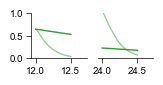

In [179]:
plt.figure(figsize=(4/2.54,1.5/2.54))

ax = plt.subplot(1,2,1)

plt.plot(t_total[ind_train + int(t_len_total)], (g_des_[1] - g_actual[ind_train+int(t_len_total)])**2/gain_var,c=green_l,lw=1)
plt.plot(t_total[ind_train + int(t_len_total)], (g_des_[1] - g_actual_slow[ind_train+int(t_len_total)])**2/gain_var,c='C2',lw=1)



# plt.ylim([-0.1, 1.])
plt.ylim([0,1])

plt.xlim([t_total[ind_train_extended[0] + int(t_len_total)], t_total[ind_train_extended[-1] + int(t_len_total)]])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax = plt.subplot(1,2,2)

plt.plot(t_total[ind_train + int(2*t_len_total)], (g_des_[2] - g_actual[ind_train+int(2*t_len_total)])**2/gain_var,c=green_l,lw=1)
plt.plot(t_total[ind_train + int(2*t_len_total)], (g_des_[2] - g_actual_slow[ind_train+int(2*t_len_total)])**2/gain_var,c='C2',lw=1)

# plt.ylim([-0.1, 1.])
plt.ylim([0,1])

plt.xlim([t_total[ind_train_extended[0] + int(2*t_len_total)], t_total[ind_train_extended[-1] + int(2*t_len_total)]])

ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Two-site model example

(Using the same model as in Figure 2)

In [166]:
# Function to pass to ODE solver
def heterosynapticOnline(t, y, head, target_gain, learn, params):
    '''
    head: a function taking a time argument that returns the head velocity
    retinal_slip: a function taking a time argument that returns the retinal slip velocity
    learn: set to True if in the training period, False if in the post-training period
    params: list containing the physiological parameters
    
    '''
    w = y[0]
    v = y[1]
    
    g = params['k_eye']*(params['mf_sensitivity']*v - 
                         params['pf_sensitivity']*params['w_pc_mvn']*(w-params['w_i']))
    retinal_slip = -(target_gain - g)*head(t)
    
    delta_mf = params['mf_sensitivity']*head(t)
    delta_pf = params['pf_sensitivity']*head(t)
    delta_cf = np.tanh(-params['beta_rs']*retinal_slip)*learn
    
    # two time constants for learning and post-training, as in Yamazaki et al. 2015
    if learn:
        tau_w = params['tau_learn']
    else:
        tau_w = params['tau_post']
    mf = params['mf_0'] + delta_mf
    pf = params['pf_0'] + delta_pf
    cf = params['cf_0'] + delta_cf

    
    delta_pc = (w - params['w_i'])*pf
    
    dydt = np.zeros(5)
    dydt[0] = 1/tau_w * (-y[0] + params['k_LTP']*y[3] - params['k_LTD']*y[4])
    dydt[1] = params['k_v']*(-y[2])
    dydt[2] = 1/params['tau_mvn'] * (-y[2] + mf*delta_pc)
    dydt[3] = 1/params['tau_f'] * (-y[3] + pf)
    dydt[4] = 1/params['tau_f'] * (-y[4] + pf*cf)
    
    return dydt

# Jacobian 
def heteroOnlineJac(t, y, head, target_gain, learn, params):
    w = y[0]
    v = y[1]
    
    g = params['k_eye']*(params['mf_sensitivity']*v - 
                         params['pf_sensitivity']*params['w_pc_mvn']*(w-params['w_i']))
    retinal_slip = -(target_gain - g)*head(t)
    
    delta_mf = params['mf_sensitivity']*head(t)
    delta_pf = params['pf_sensitivity']*head(t)
    delta_cf = np.tanh(-params['beta_rs']*retinal_slip)*learn
    
    if learn:
        tau_w = params['tau_learn']
    else:
        tau_w = params['tau_post']
    mf = params['mf_0'] + delta_mf
    pf = params['pf_0'] + delta_pf
    
    dgdw = -params['k_eye']*params['w_pc_mvn']*params['pf_sensitivity']
    dgdv = params['k_eye']*params['mf_sensitivity']
    
    jac = -1/params['tau_f']*np.eye(5)
    jac[0,:] = 1/tau_w*np.array([-1, 0, 0, params['k_LTP'], -params['k_LTD']]) 
    jac[1,:] = params['k_v']*np.array([0, -1, 0, 0, 0])
    jac[2,:] = 1/params['tau_mvn']*np.array([-mf, 0, -1, 0, 0])
    jac[4,:2] = -pf*(1-delta_cf**2)*params['beta_rs']*head(t)/params['tau_f']*np.array([dgdw, dgdv])
    return jac

In [139]:
params_twosites = copy.deepcopy(params)

In [208]:
params_twosites['k_LTD'] = params['k_LTD']*1.75
params_twosites['k_LTP'] = params['w_i']/params['pf_0'] + params_twosites['k_LTD']*params['cf_0']

In [209]:
# for ~10% consolidation
k_v_approx = 0.1*params['pf_sensitivity']/params['mf_sensitivity']*params['w_pc_mvn']/(
                params['tau_post']*(params['mf_0']*params['pf_0']))
print(k_v_approx)

3.896103896103896e-06


In [210]:
params_twosites['k_v'] = k_v_approx*0.33

In [211]:
y_0_init_twosites = np.array([params['w_i'], v_0, 0, params['pf_0'], params['pf_0']*params['cf_0']])

In [212]:
days = 3
t_len_total = len(t_learn)+len(t_post)
y_twosites = np.zeros((len(y_0_init_twosites), t_len_total*days))


y_0 = y_0_init_twosites
for d in range(days):
    sol_learn = scipy.integrate.solve_ivp(lambda t,y: heterosynapticOnline(t,y, head_learn, g_des_[d], True, params_twosites), [0, T_learn], y_0, 
                                      jac=lambda t,y: heteroOnlineJac(t,y,head_learn, g_des_[d],True,params_twosites), method='Radau', dense_output=True)
    y_learn = sol_learn.sol(t_learn)
    
    sol_recov = scipy.integrate.solve_ivp(lambda t,y: heterosynapticOnline(t,y, head_post_input, g_des_[d], False, params_twosites), [T_learn, T_post],
                                          y_learn[:,-1], 
                                          jac=lambda t,y: heteroOnlineJac(t,y,head_post_input, g_des_[d],False,params_twosites), method='Radau', dense_output=True, max_step=0.25/3600)
    y_recov = sol_recov.sol(t_post)
    y_0 = y_recov[:,-1]
    y_twosites[:,t_len_total*d:t_len_total*(d+1)] = np.hstack((y_learn, y_recov))

### Figure 4D

In [213]:
g_twosites = gain(y_twosites[0,:],y_twosites[1,:])

Amount learned during training period:

In [214]:
# Actual learning -- ideal = 75% 
((g_twosites[int(t_len_total)+len(t_learn)] - g_twosites[ind_train[0] + int(t_len_total)])/
 (g_des_[1] - g_twosites[ind_train[0] + int(t_len_total)]))*100

70.24393290312865

In [215]:
# Actual learning -- ideal = 75% 
((g_twosites[2*int(t_len_total)+len(t_learn)] - g_twosites[ind_train[0] + 2*int(t_len_total)])/
 (g_des_[2] - g_twosites[ind_train[0] + 2*int(t_len_total)]))*100

75.91285934919738

Amount consolidated post-training:

In [216]:
# ideal = 10%
((g_twosites[2*int(t_len_total)-1] - g_twosites[ind_train[0] + int(t_len_total)])/
 (g_twosites[int(t_len_total)+len(t_learn)] - g_twosites[ind_train[0] + int(t_len_total)]))*100

13.293164642247019

In [217]:
# ideal = 10%
((g_twosites[-1] - g_twosites[ind_train[0] + 2*int(t_len_total)])/
 (g_twosites[2*int(t_len_total)+len(t_learn)] - g_twosites[ind_train[0] + 2*int(t_len_total)]))*100

26.802728964447088

In [197]:
ind_train_extended = np.arange(-5,len(t_learn)+15,dtype=int)
ind_train = np.arange(0,len(t_learn),dtype=int)

In [218]:
gain_train_t2 = np.array([0,0, len(t_learn), len(t_learn)])
gain_train_t = np.array([0, len(t_learn)])

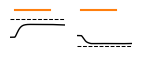

In [221]:
plt.figure(figsize=(4/2.54,1.5/2.54))

ax = plt.subplot(1,2,1)
plt.plot(t_total[ind_train_extended + int(t_len_total)], g_twosites[ind_train_extended+int(t_len_total)],c='k',lw=1)

plt.plot([t_total[ind_train_extended[0]+int(t_len_total)], t_total[ind_train_extended[-1]+int(t_len_total)]], [g_des_[1]]*2,'k--',lw=0.75)

plt.plot(t_total[gain_train_t+int(t_len_total)], [0.52,]*2,c='C1',clip_on=False)
plt.ylim([0.3, 0.5])
plt.xlim([t_total[ind_train_extended[0] + int(t_len_total)], t_total[ind_train_extended[-1] + int(t_len_total)]])


plt.axis('off')

ax = plt.subplot(1,2,2)
plt.plot(t_total[ind_train_extended + int(2*t_len_total)], g_twosites[ind_train_extended+int(2*t_len_total)],c='k', lw=1)

plt.plot([t_total[ind_train_extended[0]+int(2*t_len_total)], t_total[ind_train_extended[-1]+int(2*t_len_total)]], [g_des_[2]]*2,'k--',lw=0.75)
plt.plot(t_total[gain_train_t+2*int(t_len_total)], [0.52,]*2,c='C1',clip_on=False)
plt.ylim([0.3, 0.5])
plt.xlim([t_total[ind_train_extended[0] + int(2*t_len_total)], t_total[ind_train_extended[-1] + int(2*t_len_total)]])

plt.axis('off')

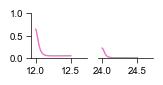

In [222]:
plt.figure(figsize=(4/2.54,1.5/2.54))

ax = plt.subplot(1,2,1)
plt.plot(t_total[ind_train + int(t_len_total)], (g_des_[1] - g_twosites[ind_train+int(t_len_total)])**2/gain_var,c='C6',lw=1)

plt.ylim([0,1])
plt.xlim([t_total[ind_train_extended[0] + int(t_len_total)], t_total[ind_train_extended[-1] + int(t_len_total)]])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(1,2,2)
plt.plot(t_total[ind_train + int(2*t_len_total)], (g_des_[2] - g_twosites[ind_train+int(2*t_len_total)])**2/gain_var,c='C6',lw=1)

plt.ylim([0,1])
plt.xlim([t_total[ind_train_extended[0] + int(2*t_len_total)], t_total[ind_train_extended[-1] + int(2*t_len_total)]])

ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# One site discrete model — stability-plasticity dilemma

Generate an example of the gain of a one-site circuit with either fast or slow learning: 

In [12]:
g_des_mu = 0.4
g_des_std = 0.1
num_trials= 200

## Generate the target gain trajectory
# g_des_1site = g_des_std*np.random.randn(num_trials)+g_des_mu
# np.save('files/target_gain_1site.npy',g_des_1site)

In [8]:
g_des_1site = np.load('files/target_gain_1site.npy')

In [9]:
w_discrete_fast = np.zeros(len(g_des_1site)+1)
w_discrete_fast[0] = -1/(params['k_eye']*params['pf_sensitivity'])*0.4

err_bef_fast = np.zeros(len(g_des_1site)+1) # signed error measured at start of training session
err_aft_fast = np.zeros(len(g_des_1site)+1) # signed error measured at end of session

q = 0.75 # 75% learning


for i in range(1,len(g_des_1site)):
    w_des = -1/(params['k_eye']*params['pf_sensitivity'])*g_des_1site[i]
    w_discrete_fast[i] = w_discrete_fast[0] + q*(w_des - w_discrete_fast[0])
    err_bef_fast[i] = (g_des_1site[i] + params['k_eye']*params['pf_sensitivity']*w_discrete_fast[i-1])
    err_aft_fast[i] = (g_des_1site[i] + params['k_eye']*params['pf_sensitivity']*w_discrete_fast[i])

In [10]:
w_discrete_slow = np.zeros(len(g_des_1site)+1)
w_discrete_slow[0] = -1/(params['k_eye']*params['pf_sensitivity'])*0.4

err_bef_slow = np.zeros(len(g_des_1site)+1)
err_aft_slow = np.zeros(len(g_des_1site)+1)

q = 0.1 # 10% learning

for i in range(1,len(g_des_1site)):
    w_des = -1/(params['k_eye']*params['pf_sensitivity'])*g_des_1site[i]
    w_discrete_slow[i] = w_discrete_slow[0] + q*(w_des - w_discrete_slow[0])
    err_bef_slow[i] = (g_des_1site[i] + params['k_eye']*params['pf_sensitivity']*w_discrete_slow[i-1])
    err_aft_slow[i] = (g_des_1site[i] + params['k_eye']*params['pf_sensitivity']*w_discrete_slow[i])

## Figure 4B

In [13]:
trials = np.arange(num_trials)

(0.0, 0.8)

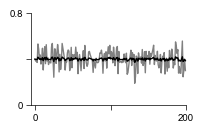

In [17]:
plt.figure(figsize=(2,1.2))

plt.plot(trials,-(params['k_eye']*params['pf_sensitivity'])*w_discrete_fast[:-1],c=(0.5,)*3,markersize=3,lw=1,clip_on=False)
plt.plot(trials, -(params['k_eye']*params['pf_sensitivity'])*w_discrete_slow[:-1],c='k',markersize=3,lw=1,clip_on=False)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks([0,100,200],[0,'',200])
plt.yticks([0, 0.4, 0.8],[0,'',  0.8])
plt.xlim([-5,200])
plt.ylim([0,0.8])

## Figure 4C – theoretical stability-plasticity tradeoff curve for 1-site model

Plotting idealized mean squared error at start of training session vs. after training, according to calculations in the Materials and Methods, _Comparing a one-site and two-site model_.

In [18]:
err_bef_ideal_1site = lambda q, sigma2: 2/(2-q)*sigma2
err_aft_ideal_1site = lambda q, sigma2: (1-q)**2*err_bef_ideal_1site(q, sigma2)

In [19]:
q_ideal = np.linspace(0, 1,50)[1:-1]

In [23]:
green_l = make_rgb_transparent(matplotlib.colors.to_rgb('C2'), [1,1,1],0.5)

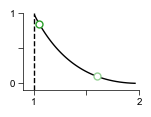

In [44]:
plt.figure(figsize=(1.5,1))
plt.plot([1,1],[-0.1,1],'k--',lw=1)
plt.plot(err_bef_ideal_1site(q_ideal, g_des_std**2)/g_des_std**2, err_aft_ideal_1site(q_ideal, g_des_std**2)/g_des_std**2,clip_on=False,c='k',lw=1)

plt.plot(err_bef_ideal_1site(0.1, g_des_std**2)/g_des_std**2, err_aft_ideal_1site(0.1, g_des_std**2)/g_des_std**2, 'o',ms=5, markeredgecolor='C2', markerfacecolor='w')
plt.plot(err_bef_ideal_1site(0.75, g_des_std**2)/g_des_std**2, err_aft_ideal_1site(0.75, g_des_std**2)/g_des_std**2, 'o', ms=5,markeredgecolor=green_l, markerfacecolor='w')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim([-0.1,1])
plt.xlim([0.9,2])

plt.xticks(np.linspace(1, 2,3), [1, '',2 ])
plt.yticks([0,0.5,1],[0,'',1])

# Two-site discrete model

In [26]:
g_des_mu_1 = 0.4
g_des_mu_2 = 2
g_des_std = 0.1
num_trials_1 = 50
num_trials_2 = 150

## Generate the target gain trajectory
# g_des_1 =g_des_std*np.random.randn(num_trials_1)+g_des_mu_1
# g_des_2 = g_des_std*np.random.randn(num_trials_2)+g_des_mu_2

# g_des_full = np.concatenate((g_des_1,g_des_2))

# np.save('files/target_gain_2sites.npy',g_des_full)

In [27]:
g_des_full = np.load('files/target_gain_2sites.npy')

In [28]:
v_discrete_fast = np.zeros(len(g_des_full)+1)
v_discrete_fast[0] = v_0
w_discrete_2_fast = np.zeros(len(g_des_full)+1)

p = 0.75*params['w_pc_mvn']*params['pf_sensitivity']/params['mf_sensitivity'] # 75% consolidation

for i in range(len(g_des_full)):
    w_discrete_2_fast[i] = -1/(params['pf_sensitivity']*params['w_pc_mvn']*params['k_eye'])*(g_des_full[i] - 
                      params['k_eye']*params['mf_sensitivity']*v_discrete_fast[i]) + params['w_i']
    v_discrete_fast[i+1] = v_discrete_fast[i] - p*(w_discrete_2_fast[i]-params['w_i'])

In [29]:
v_discrete_slow = np.zeros(len(g_des_full)+1)
v_discrete_slow[0] = v_0
w_discrete_2_slow = np.zeros(len(g_des_full)+1)

p = 0.1*params['w_pc_mvn']*params['pf_sensitivity']/params['mf_sensitivity'] # 10% consolidation

for i in range(len(g_des_full)):
    w_discrete_2_slow[i] = -1/(params['pf_sensitivity']*params['w_pc_mvn']*params['k_eye'])*(g_des_full[i] - 
                      params['k_eye']*params['mf_sensitivity']*v_discrete_slow[i]) + params['w_i']
    v_discrete_slow[i+1] = v_discrete_slow[i] - p*(w_discrete_2_slow[i]-params['w_i'])

## Figure 4F

Plot example gain of circuit after consolidation with either fast or slow rate of learning at the late-learning site in response to a random target gain signal, showing a change in the mean of the target gain.

In [30]:
trials = np.arange(num_trials_1+num_trials_2)

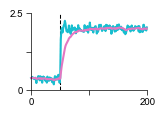

In [32]:
plt.figure(figsize=(1.5,1))
plt.plot([num_trials_1,]*2, [0, 2.5],'k--', lw=0.75)
plt.plot(trials, gain(params['w_i'],v_discrete_fast)[:-1],clip_on=False, c='C9',lw=1.5)
plt.plot(trials, gain(params['w_i'],v_discrete_slow)[:-1],clip_on=False,c='C6',lw=1.5)


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim([0, 200])
plt.ylim([0., 2.5])
plt.xticks([0,100,200],[0,'',200])
plt.yticks([0., 1.25, 2.5], [0,'',2.5])

## Figure 4E – comparing the 1-site and 2-site models

In [34]:
err_bef_ideal_2site = lambda p,q, sigma2: 2/(2 - p*q)*sigma2
err_aft_ideal_2site = lambda p,q, sigma2: (1-q)**2*err_bef_2site(p,q,sigma2)

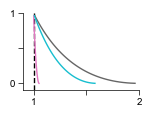

In [45]:
plt.figure(figsize=(1.5,1))
plt.plot([1,1],[-0.1,1],'k--',lw=1)
# Replot 1-site curve
plt.plot(err_bef_ideal_1site(q_ideal, g_des_std**2)/g_des_std**2, err_aft_ideal_1site(q_ideal, g_des_std**2)/g_des_std**2,
         clip_on=False,c=(0.4,)*3,lw=1)

# Plot 10% consolidation curve
plt.plot(err_bef_ideal_2site(0.1, q_ideal, g_des_std**2)/g_des_std**2, err_aft_ideal_2site(0.1, q_ideal, g_des_std**2)/g_des_std**2,
         clip_on=False,c='C6',lw=1)

# Plot 75% consolidation curve
plt.plot(err_bef_ideal_2site(0.75, q_ideal, g_des_std**2)/g_des_std**2, err_aft_ideal_2site(0.75, q_ideal, g_des_std**2)/g_des_std**2,
         clip_on=False,c='C9',lw=1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim([-0.1,1])
plt.xlim([0.9,2])

plt.xticks(np.linspace(1, 2,3), [1, '',2 ])
plt.yticks([0,0.5,1],[0,'',1])